In [5]:
#Import Statements
import xarray as xr
import gcsfs
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import intake
from scipy.signal import detrend

In [6]:
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds_faces1 = cat["ECCOv4r3"].to_dask()
ds_faces2 = xr.open_zarr(gcsfs.GCSMap('pangeo-data/ECCO_layers.zarr'))
ds_faces=xr.merge((ds_faces1,ds_faces2))

In [7]:
ds_ll = faces_dataset_to_latlon(ds_faces, metric_vector_pairs=[('LaHw3RHO','LaHs3RHO')])#.compute()
ds = (ds_ll.reset_coords(drop=True).roll(i=180, roll_coords=False).roll(i_g=180, roll_coords=False))
coords = (ds_ll.coords.to_dataset().reset_coords().roll(i=180, roll_coords=False).roll(i_g=180, roll_coords=False))

In [8]:
#ds.dt 
dt = ds.time_snp[1:].load()
dt.values = [float(t)/10**9 for t in np.diff(ds.time_snp)]
dt = dt.rename({'time_snp':'time'})
dt.time.values = ds.time[1:-1].values 
ds = ds.assign_coords(dt=dt)
ds.dt.attrs = {'units': 's','standard_name': 'dt','coordinate': 'time','long_name': 'time span between snapshots'}

In [9]:
#mask
def atlMask(newMask):
    #mask[ydimension, xdimnesion]
    newMask[215:, 0:147] = 0 #fixes top left pixel
    newMask[215:, 260:] = 0
    newMask[185:215, :120] = 0
    newMask[185:215, 260:] = 0 #right 
    newMask[185:199, 250:] = 0 #right
    newMask[:185, :133] = 0 #responsible for bottom left pixel
    newMask[:180, :141] = 0 #fixse bottom left pixeel 
    newMask[:185, 245:] = 0
    newMask[115:145, 135:155] = 0
    for j in coords.j[55:125]:
        for i in coords.i[205:245]:
            if j < (7/4)*i - 303.75:
                newMask[j,i] = 0
    return newMask
mask = atlMask(coords.hFacS.isel(k=0).load())

In [10]:
#For use later 
#Advection term - deg C m^3 per second 
rho0=1029 
cp=3994
a = (ds.LaAy3RHO * mask * rho0 * cp*ds.dt)[:, :, 220, :] #(time, l3_c, i)

In [11]:
#Top left region
top_left = a[:, :103, :190].sum(['i','l3_c'])

In [12]:
#Top left with 79 instead 
top_left79 = a[:, :103, :189].sum(['i','l3_c'])

In [13]:
#Top right region 
top_right = a[:, :103, 190:].sum(['i','l3_c'])

In [14]:
#Top right with 79 
top_right79 = a[:, :103, 189:].sum(['i','l3_c'])

In [15]:
#Bottom  region 
bottom = a[:, 103:, :].sum(['i','l3_c'])

In [16]:
#Strip transport with 0.83 factor 
strip = (a[:, :103, 189:190].sum(['i','l3_c']))* 0.83

In [17]:
#Interpolated
adv_interp_left = top_left79 + strip 
adv_interp_right = top_left + top_right - adv_interp_left

In [18]:
#Interpolated cumsums over time 
interp_left_cs = adv_interp_left.cumsum('time')
interp_right_cs= adv_interp_right.cumsum('time')

In [19]:
#Interpolated cumsums over time, detrended - these are spiky
interp_left_detrend = xr.apply_ufunc(detrend, interp_left_cs.load().fillna(0),kwargs={'axis': 0}).where(~interp_left_cs.isnull())
interp_right_detrend = xr.apply_ufunc(detrend, interp_right_cs.load().fillna(0),kwargs={'axis': 0}).where(~interp_right_cs.isnull())

In [ ]:
#Getting box sizes - top left 
s = ds.LaHs3RHO.isel(j_g=220)
left_size = (s[:, :103, :190] * coords.dxG[220, :190]).sum(['i','l3_c'])

In [ ]:
#top right, bottom box size
right_size = (s[:, :103, 190:] * coords.dxG[220, 190:]).sum(['i','l3_c'])
bottom_size = (s[:, 103:, :] * coords.dxG[220, :]).sum(['i','l3_c'])

In [ ]:
#Throughflow 
v = ((ds.VVELMASS[:, :, 220, :])* coords.drF * (coords.dxG[220, :]) * mask[220, :]).sum(['i','k']) 
area =( coords.drF * (coords.dxG[220, :]) * mask[220, :]).sum(['i','k'])
t = ((ds.THETA[:, :, 220, :])* coords.drF * (coords.dxG[220, :]) * mask[220, :]).sum(['i','k'])
net_tf_adv = (v * t) / (area*area)

In [ ]:
#REgional throughflow advection - multiplying by rh0 and cp after integral (same as doing it before )
topleft_tf_adv = net_tf_adv * left_size* rho0 * cp
topright_tf_adv = net_tf_adv * right_size * rho0 * cp
bottom_tf_adv = net_tf_adv * bottom_size * rho0 * cp

In [ ]:
#net- removing throughflow first from the linearly interpolated number and then cumsumming
left_net = (adv_interp_left - topleft_tf_adv).cumsum('time')
right_net = (adv_interp_right - topright_tf_adv).cumsum('time')
bottom_net = (bottom - bottom_tf_adv).cumsum('time')

In [ ]:
#Detrending after cumsumming
left_net_detrend = xr.apply_ufunc(detrend, left_net.load().fillna(0),kwargs={'axis': 0}).where(~left_net.isnull())
right_net_detrend = xr.apply_ufunc(detrend, right_net.load().fillna(0),kwargs={'axis': 0}).where(~right_net.isnull())
bottom_net_detrend = xr.apply_ufunc(detrend, bottom_net.load().fillna(0),kwargs={'axis': 0}).where(~bottom_net.isnull())

In [ ]:
#Total 
net = left_net_detrend + right_net_detrend + bottom_net_detrend 
sum_net = left_net_detrend + right_net_detrend

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
left_net_detrend.plot(ax=ax)
right_net_detrend.plot(ax=ax)
bottom_net_detrend.plot(ax=ax)
ax.legend(("Upper AMOC", "Gyre","DWBC"),loc='upper left')

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
left_net_detrend.plot(ax=ax, color = 'grey')
right_net_detrend.plot(ax=ax, color = 'orange')
bottom_net_detrend.plot(ax=ax)
net.plot(ax=ax, color='black')
plt.grid()
ax.legend(("Upper AMOC", "Gyre","DWBC", "Total"),loc='upper left')
plt.ylabel('Cumulative Heat Transport (J)')

In [20]:
#Getting box sizes - top left with ds.dt 
s = ds.LaHs3RHO.isel(j_g=220)
left_size = (s[:, :103, :190] * coords.dxG[220, :190] * ds.dt).sum(['i','l3_c'])

In [21]:
#top right, bottom box size- ds.dt
right_size = (s[:, :103, 190:] * coords.dxG[220, 190:] *ds.dt).sum(['i','l3_c'])
bottom_size = (s[:, 103:, :] * coords.dxG[220, :]*ds.dt).sum(['i','l3_c'])

In [22]:
#Throughflow - ds.dt
v = ((ds.VVELMASS[:, :, 220, :])* coords.drF * (coords.dxG[220, :]) * mask[220, :]*ds.dt).sum(['i','k']) 
area =( coords.drF * (coords.dxG[220, :]) * mask[220, :]* ds.dt).sum(['i','k'])
t = ((ds.THETA[:, :, 220, :])* coords.drF * (coords.dxG[220, :]) * mask[220, :] * ds.dt).sum(['i','k'])
net_tf_adv = (v * t) / (area*area)

In [23]:
#REgional throughflow advection - multiplying by rh0 and cp after integral (same as doing it before ) ds.dt
topleft_tf_adv = net_tf_adv * left_size* rho0 * cp
topright_tf_adv = net_tf_adv * right_size * rho0 * cp
bottom_tf_adv = net_tf_adv * bottom_size * rho0 * cp

In [24]:
#net- removing throughflow first from the linearly interpolated number and then cumsumming
left_net = (adv_interp_left - topleft_tf_adv).cumsum('time')
right_net = (adv_interp_right - topright_tf_adv).cumsum('time')
bottom_net = (bottom - bottom_tf_adv).cumsum('time')

In [25]:
#Detrending after cumsumming
left_net_detrend = xr.apply_ufunc(detrend, left_net.load().fillna(0),kwargs={'axis': 0}).where(~left_net.isnull())
right_net_detrend = xr.apply_ufunc(detrend, right_net.load().fillna(0),kwargs={'axis': 0}).where(~right_net.isnull())
bottom_net_detrend = xr.apply_ufunc(detrend, bottom_net.load().fillna(0),kwargs={'axis': 0}).where(~bottom_net.isnull())

In [26]:
#Total 
net = left_net_detrend + right_net_detrend + bottom_net_detrend 
sum_net = left_net_detrend + right_net_detrend

Text(0, 0.5, 'Cumulative Heat Transport (J)')

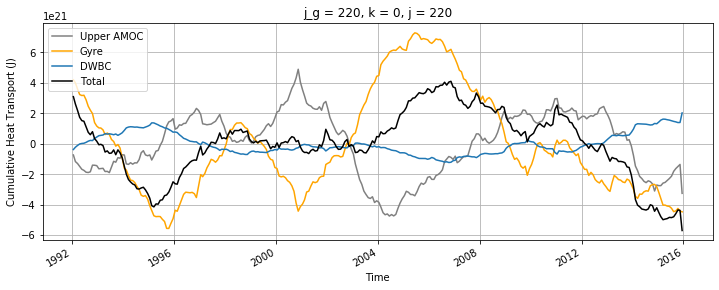

In [27]:
fig, ax = plt.subplots(figsize=(12,4))
left_net_detrend.plot(ax=ax, color = 'grey')
right_net_detrend.plot(ax=ax, color = 'orange')
bottom_net_detrend.plot(ax=ax)
net.plot(ax=ax, color='black')
plt.grid()
ax.legend(("Upper AMOC", "Gyre","DWBC", "Total"),loc='upper left')
plt.ylabel('Cumulative Heat Transport (J)')

Text(0, 0.5, 'Cumulative Heat Transport (J)')

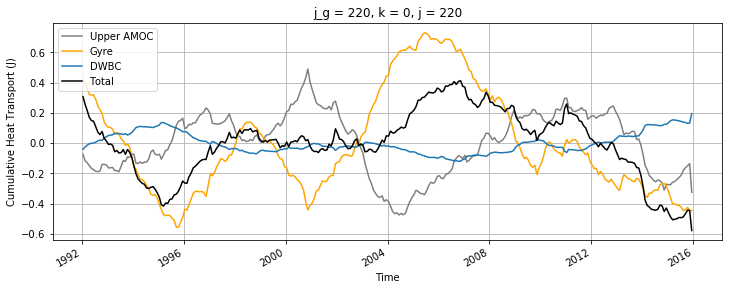

In [27]:
fig, ax = plt.subplots(figsize=(12,4))
(1e-22*left_net_detrend).plot(ax=ax, color = 'grey')
(1e-22*right_net_detrend).plot(ax=ax, color = 'orange')
(1e-22*bottom_net_detrend).plot(ax=ax)
(1e-22*net).plot(ax=ax, color='black')
plt.grid()
ax.legend(("Upper AMOC", "Gyre","DWBC", "Total"),loc='upper left')
plt.ylabel('Cumulative Heat Transport (J)')